In [1]:
# import dependency
import torch
import numpy as np
from torch.autograd import Variable as V
import torchvision
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.nn import functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt

from functools import partial
import pickle

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
# set up pickle to support encoding of the trained 2.7 weight
pickle.load = partial(pickle.load, encoding="latin1")
pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")

In [3]:
# define our transformation function
centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# load the data with cocoAPI
cap = dset.CocoCaptions(root = '/home/raille/coco-features/coco-dataset/val2017',
                        annFile = '/home/raille/coco-features/coco-dataset/annotations/captions_val2017.json',
                        transform=centre_crop)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [5]:
# print out one example of data
print('Number of samples: ', len(cap))
img, target = cap[3] # load 4th sample

print("Image Size: ", img.size())
print(target)

Number of samples:  5000
Image Size:  torch.Size([3, 224, 224])
['A person on a skateboard and bike at a skate park.', 'A man on a skateboard performs a trick at the skate park', 'A skateboarder jumps into the air as he performs a skateboard trick.', 'Athletes performing tricks on a BMX bicycle and a skateboard.', 'a man falls off his skateboard in a skate park.']


In [6]:
# create dataloader to iterate over the dataset in batch of images
batch_size = 4
dataloders = torch.utils.data.DataLoader(cap, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
len(dataloders)

1250

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # .numpy() Returns this tensor as a NumPy ndarray. 
    # This tensor and the returned ndarray share the same underlying storage. 
    # Changes to this tensor will be reflected in the ndarray and vice versa.
    # .tranpose change the ndarray from 3x228x906 to 228x906x3 -> used probably by imshow)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # reverse the normalization applied
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 224, 224])


[('A dog in a small bathroom with an orange shower curtain.',
  'A large white sheep next to a small black one',
  'Three laptop computers and a desktop computer sit next to each other.',
  'A small kitten standing in a  blue hat on top of a table.'),
 ('A dog that is standing on a rug in a bathroom.',
  'A lamb and a sheep are out in the field together. ',
  'Four computers are turned on on a desk.',
  'a cat sitting inside of a plastic bucket'),
 ('A small dug stands on a white rug in the bathroom.',
  'The two sheep are standing next to each other in the field. ',
  'a office with three computers spread out everywhere',
  "A cat's image is blurred as he tumbles in a bowl near a food scale and pen and paper on a table."),
 ('The dog was standing in the bathroom near the sink and toilet.',
  'Pair of sheep standing on open grassy field on clear day.',
  'Four computers and keyboards arranged on a desk.',
  'A kitty cat jumping out of a blue bowl '),
 ('A puppy sitting on the ground in

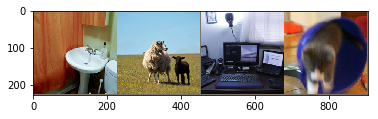

In [9]:
# try out the dataloader
inputs, captions = next(iter(dataloders))
print(inputs.size())

out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out)
captions

In [10]:
captions_list = []
for i in range(batch_size):
    captions_list.append([caption[i] for caption in captions])
captions_list

[['A dog in a small bathroom with an orange shower curtain.',
  'A dog that is standing on a rug in a bathroom.',
  'A small dug stands on a white rug in the bathroom.',
  'The dog was standing in the bathroom near the sink and toilet.',
  'A puppy sitting on the ground in a bathroom'],
 ['A large white sheep next to a small black one',
  'A lamb and a sheep are out in the field together. ',
  'The two sheep are standing next to each other in the field. ',
  'Pair of sheep standing on open grassy field on clear day.',
  'A ewe and her kid in a field.'],
 ['Three laptop computers and a desktop computer sit next to each other.',
  'Four computers are turned on on a desk.',
  'a office with three computers spread out everywhere',
  'Four computers and keyboards arranged on a desk.',
  'A lot of computers that are on a computer desk.'],
 ['A small kitten standing in a  blue hat on top of a table.',
  'a cat sitting inside of a plastic bucket',
  "A cat's image is blurred as he tumbles in a

In [11]:
# now load the model
arch = 'resnet18'

model_file = 'whole_%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/whole_%s_places365.pth.tar' % arch
    os.system('wget ' + weight_url)

useGPU = torch.cuda.is_available()
if useGPU == 1:
    model = torch.load(model_file)
    model = model.cuda()
else:
    model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle) # model trained in GPU could be deployed in CPU machine like this!

# put the model in eval mode (no dropout / batchnorm...)
model.eval()

/home/raille/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [12]:
# create a custom forward function to get only the final features just before the fc
def my_forward(x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    x = model.avgpool(x)
    # reshape the tensor into a #images * n vector
    x = x.view(x.size(0), -1)
    
    return x

In [13]:
# create a FloatTensor to gather all the features
if useGPU:
    features = torch.cuda.FloatTensor(len(cap), 512)
else:
    features = torch.FloatTensor(len(cap), 512)
    
# and a corresponding caption list
captions_list = []

# and a tensor to store the images to be able to compare the order
if useGPU:
    images = torch.cuda.FloatTensor(len(cap), 3, 224, 224)
else:
    images = torch.FloatTensor(len(cap), 3, 224, 224)

In [15]:
# run the pretrained model on the data and put the collected feature in the features tensor
for i, data in enumerate(dataloders):
    inputs, captions = data

    if useGPU:
        inputs = V(inputs.cuda())
    else:
        inputs = V(inputs)
        
    images[i*batch_size:(i+1)*batch_size] = inputs.data
    features[i*batch_size:(i+1)*batch_size] = my_forward(inputs).data
    
    for i in range(batch_size):
        captions_list.append([caption[i] for caption in captions])
        captions_list

In [19]:
len(images)

5000

In [20]:
images[1]


( 0 ,.,.) = 
  1.5810  1.5810  1.5810  ...   1.6495  1.6495  1.6495
  1.5810  1.5810  1.5810  ...   1.6495  1.6667  1.6495
  1.5810  1.5810  1.5810  ...   1.6495  1.6667  1.6495
           ...             ⋱             ...          
 -0.8335 -0.7993 -0.7822  ...  -0.3541 -0.3027 -0.3198
 -0.8335 -0.8678 -0.8335  ...  -0.2856 -0.3198 -0.2856
 -0.5596 -0.5596 -0.5082  ...  -0.3369 -0.3541 -0.3198

( 1 ,.,.) = 
  1.7633  1.7633  1.7633  ...   1.7983  1.7983  1.7983
  1.7633  1.7633  1.7633  ...   1.7983  1.8158  1.7983
  1.7633  1.7633  1.7633  ...   1.7983  1.8158  1.7983
           ...             ⋱             ...          
 -0.6877 -0.6702 -0.6527  ...  -0.2325 -0.1800 -0.1975
 -0.6877 -0.7052 -0.6702  ...  -0.1625 -0.1975 -0.1625
 -0.4601 -0.4426 -0.3901  ...  -0.2150 -0.2325 -0.1800

( 2 ,.,.) = 
  1.8731  1.8731  1.8731  ...   1.9254  1.9254  1.9254
  1.8731  1.8731  1.8731  ...   1.9254  1.9428  1.9254
  1.8731  1.8731  1.8731  ...   1.9254  1.9428  1.9254
           ...         

In [21]:
# save images on a pickle to be able to load it later
torch.save(images, 'images.pt')

In [22]:
len(captions_list)

5000

In [23]:
len(features)

5000

In [24]:
# we now have a feature matrix of size n * number of features
features[-4:]


 0.1733  0.0451  0.0190  ...   0.1608  1.8456  0.0000
 0.0671  0.0989  0.0113  ...   0.2617  0.7807  0.6469
 0.2934  0.1945  0.9250  ...   0.1170  0.4070  0.1099
 0.0439  0.1702  0.4204  ...   1.7394  0.2452  0.1753
[torch.cuda.FloatTensor of size 4x512 (GPU 0)]

In [25]:
# save the list of catpions
with open('captions.pkl', 'wb') as f:
    pickle.dump(captions_list, f)

In [26]:
# save the raw features extracted
torch.save(features, 'raw-features.pt')

In [27]:
# Perform the standardization of the data
for i in range(features.shape[1]):
    features[:, i].add_(-torch.mean(features[:, i]))
    features[:, i].div_(torch.std(features[:, i]))

In [28]:
# Perform the PCA through SVD
U, S, V = torch.svd(features)

In [29]:
# Keep only the principal component
k = 128
PC_k = torch.mm(U[:, 0:k], torch.diag(S)[0:k,0:k])

In [30]:
PC_k


-8.4063e+00 -7.1521e+00 -7.8016e-01  ...  -8.8180e-01 -5.0255e-01 -7.2228e-01
-6.5140e+00  4.4774e+00  4.4884e+00  ...  -9.5864e-01 -1.0499e-01  7.2858e-01
-3.1564e+00  5.3898e+00  3.1564e+00  ...   6.6038e-01 -1.3145e+00 -4.5129e-01
                ...                   ⋱                   ...                
-7.3145e+00 -4.8327e+00 -2.5488e+00  ...   9.1882e-01 -6.7384e-01 -9.3270e-02
 4.9693e+00 -4.6637e-01  9.9329e+00  ...  -2.1649e-01 -4.1381e-01 -1.1081e+00
-2.6722e+00 -1.2596e+00  4.2186e+00  ...   8.1245e-01  1.0686e+00  3.6901e-01
[torch.cuda.FloatTensor of size 5000x128 (GPU 0)]

In [31]:
# save the reduced matrice
torch.save(PC_k, 'PCA-features.pt')